In [92]:
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import linear_model
from statsmodels.graphics.regressionplots import plot_ccpr
from statsmodels.sandbox.predict_functional import predict_functional

import seaborn as sns
sns.set_style("white")
%matplotlib inline

In [93]:
# source of data: https://data.ca.gov/dataset/covid-19-cases (5th of July)
data = pd.read_csv('./statewide_cases.csv', parse_dates=['date'])
data.sort_values(by=['county', 'date'], inplace=True)
print(data.describe())
data['calendar_day'] = data['date'].dt.dayofyear
data['calendar_day_scaled'] = data['calendar_day'] - data['calendar_day'].min()
data['totalcountconfirmed_log'] = np.log(data['totalcountconfirmed'].apply(lambda x: 1 if x == 0 else x))
#data['totalcountconfirmed_diff'] = data.groupby('county')['totalcountconfirmed'].diff().fillna(0)
data['newcountconfirmed'] = data['newcountconfirmed'].apply(lambda x: 0 if x < 0 else x)
data.set_index('date', inplace=True)

data = data[data['county'] != 'Los Angeles']
var = ['county', 'totalcountconfirmed', 'totalcountconfirmed_log', 'newcountconfirmed', 'calendar_day_scaled']
data = data[var].dropna()

       totalcountconfirmed  totalcountdeaths  newcountconfirmed  \
count          6482.000000       6483.000000        6485.000000   
mean           1429.587627         48.185254          40.116423   
std            6726.690637        256.846562         164.961795   
min               0.000000          0.000000         -51.000000   
25%               7.000000          0.000000           0.000000   
50%              59.000000          1.000000           2.000000   
75%             639.000000         16.000000          19.000000   
max          107256.000000       3454.000000        2843.000000   

       newcountdeaths  
count     6485.000000  
mean         0.976253  
std          4.967264  
min         -3.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max         81.000000  


In [94]:
data.head()

,county,totalcountconfirmed,totalcountconfirmed_log,newcountconfirmed,calendar_day_scaled
date,,,,,
2020-03-18,Alameda,29.0,3.367296,29,0
2020-03-19,Alameda,36.0,3.583519,7,1
2020-03-20,Alameda,42.0,3.737670,6,2
2020-03-21,Alameda,62.0,4.127134,20,3
2020-03-22,Alameda,72.0,4.276666,10,4


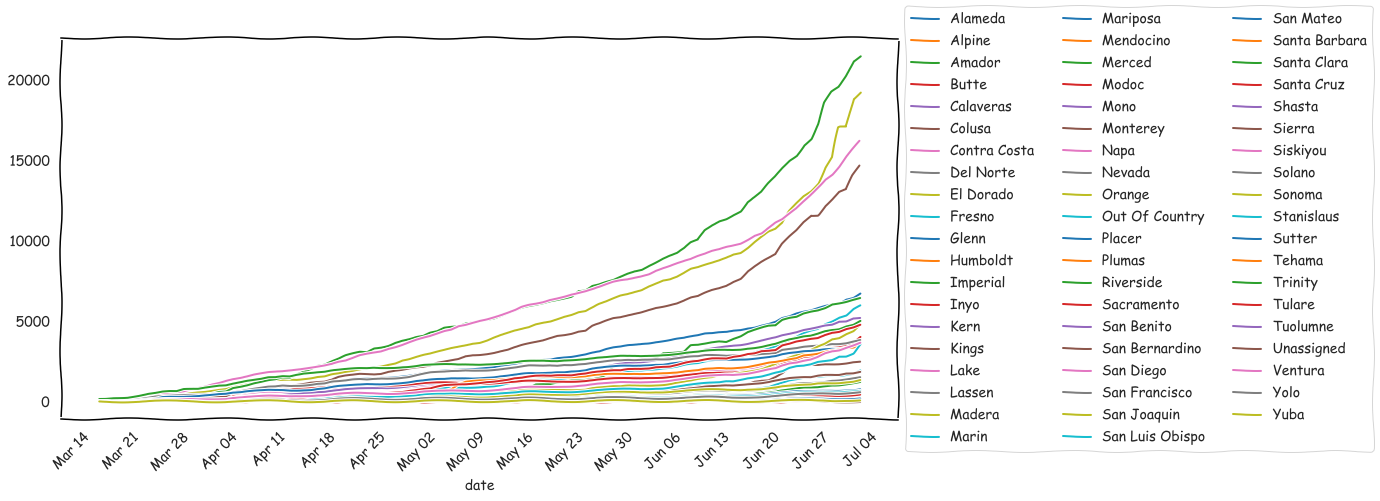

In [95]:
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(15, 7))
    data.groupby(['date', 'county']).sum()['totalcountconfirmed'].unstack().plot(ax=ax)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=3)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.xticks(rotation=45)

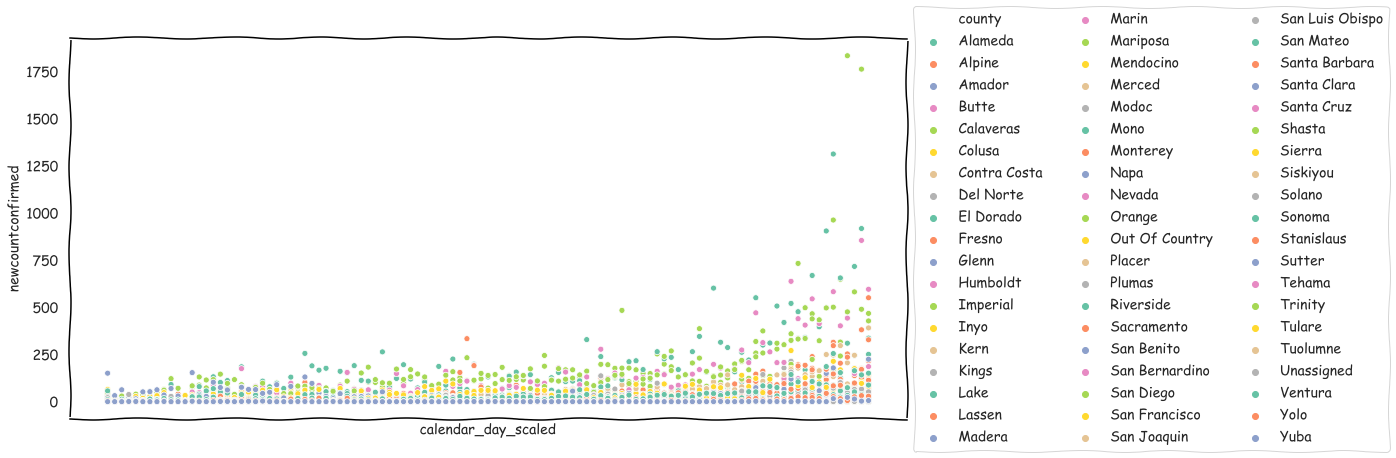

In [96]:
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(15, 7))
    #data.groupby(['date', 'county']).sum()['totalcountconfirmed_diff'].unstack().plot.scatter(x='date', y='totalcountconfirmed_diff', ax=ax)
    sns.scatterplot(data=data, x='calendar_day_scaled', y='newcountconfirmed',
                    hue='county', ax=ax, palette="Set2")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=3)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58]),
 <a list of 59 Text xticklabel objects>)

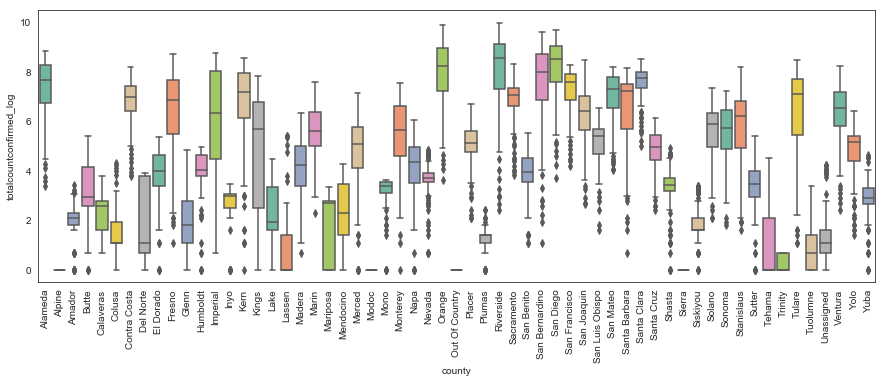

In [97]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=data, palette="Set2", x='county', y='totalcountconfirmed_log', ax=ax)
plt.xticks(rotation=90)

## Significance Testing

In [98]:
mlm_mod = sm.MixedLM.from_formula(
    formula = 'totalcountconfirmed ~ calendar_day_scaled', 
    groups = 'county', 
    re_formula="0 + calendar_day_scaled", 
    data=data
).fit()
print(mlm_mod.summary())

ols_mod = sm.OLS.from_formula(
    formula = 'totalcountconfirmed ~ calendar_day_scaled',
    data = data
).fit()
print(ols_mod.summary())

                  Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   totalcountconfirmed
No. Observations:     6373      Method:               REML               
No. Groups:           59        Scale:                278353.4693        
Min. group size:      83        Likelihood:           -49193.4789        
Max. group size:      109       Converged:            Yes                
Mean group size:      108.0                                              
-------------------------------------------------------------------------
                         Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------------------
Intercept               -286.902   13.247 -21.658 0.000 -312.866 -260.939
calendar_day_scaled       19.655    3.660   5.371 0.000   12.482   26.828
calendar_day_scaled Var  787.643    0.279                                

                             OLS Regression Results    

* Mixed Model (with random slope): -2 * REML log-likelihood = 98,386.94
* OSL (without random slope): -2 * REML log-likelihood = 113,798.00 (worse fit!)
- Test Statistic (TS) = 113,798.00 – 98,386.94 = 15,411.06

In [99]:
# Refer the TS to a mixture of chi-square distributions with 1 and 2 DF, and equal weight 0.5
pval = 0.5 * (1 - chi2.cdf(15411.06, 1)) 
print("The p-value of significance test is: {0}".format(pval))

The p-value of significance test is: 0.0


***Reject the null hypothesis that the variance of the random date effects on the slope is zero***

## Spaghetti Charts

/Users/milad/anaconda/envs/mlbook/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  totalcountconfirmed_log
No. Observations:    6373     Method:              REML                   
No. Groups:          59       Scale:               0.2820                 
Min. group size:     83       Likelihood:          -5369.4999             
Max. group size:     109      Converged:           Yes                    
Mean group size:     108.0                                                
--------------------------------------------------------------------------
                                 Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        2.292    0.270  8.478 0.000  1.762  2.822
calendar_day_scaled              0.033    0.002 14.787 0.000  0.028  0.037
county Var                       4.301    1.515                           
county x calendar_day_scaled Cov 0.006    0.

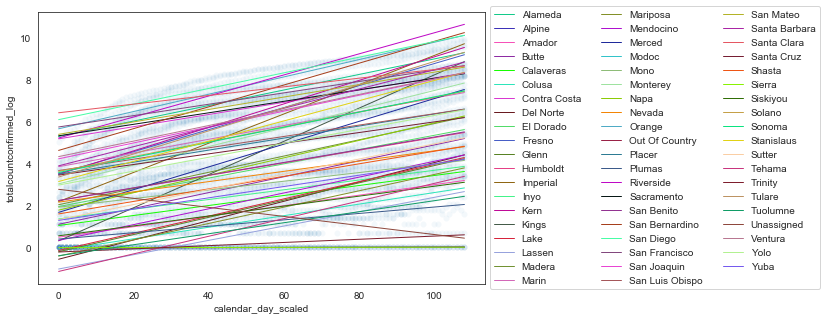

In [100]:
mlm_mod = sm.MixedLM.from_formula(
    formula = 'totalcountconfirmed_log ~ calendar_day_scaled', 
    groups = 'county', 
    re_formula="1 + calendar_day_scaled", 
    data=data
).fit()
print(mlm_mod.summary())

data['totalcountconfirmed_hat'] = mlm_mod.fittedvalues
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(x='calendar_day_scaled', y='totalcountconfirmed_log', data=data, alpha=0.05, 
                palette='Paired', legend='full', x_jitter=0.5, ax=ax)
for idx, _id in enumerate(data['county'].unique().tolist()):
        c=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
        ax.plot(data[data['county'] == _id].calendar_day_scaled, 
                data[data['county'] == _id].totalcountconfirmed_hat,
                c=c, label=str(_id), linewidth=1, alpha=1)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=3)

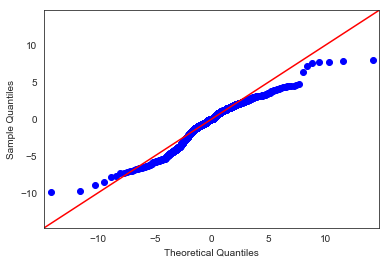

In [101]:
fig = sm.qqplot(mlm_mod.resid.values, stats.t, fit=True, line='45')

## Comparing with other datasets

In [102]:
# https://data.ca.gov/dataset/health-professional-shortage-area-mental-health
mental = pd.read_csv('./Shortage_Area_Mental_Health.csv')
mental.rename(columns={"COUNTY": "county"}, inplace=True)
#print(mental.columns)

covid_max = data[['county','newcountconfirmed']].groupby(['county']).max().reset_index().copy()
#mental_score = mental[['county', 'SCORE']].groupby('county').mean().reset_index().copy()
mental_powerty = mental[['county', 'POVERTY_UN']].groupby('county').mean().reset_index().copy()

merged = pd.merge(left=covid_max, right=mental_powerty, left_on='county', right_on='county')
merged['diff_log'] = np.log(merged['newcountconfirmed'])

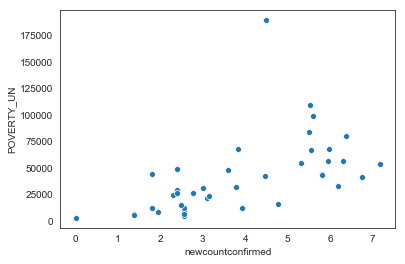

In [103]:
 sns.scatterplot(data=merged, x=np.log(merged['newcountconfirmed']), y=merged['POVERTY_UN'])

                            OLS Regression Results                            
Dep. Variable:             POVERTY_UN   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     21.25
Date:                Tue, 07 Jul 2020   Prob (F-statistic):           4.07e-05
Time:                        16:37:30   Log-Likelihood:                -490.71
No. Observations:                  42   AIC:                             985.4
Df Residuals:                      40   BIC:                             988.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -203.7714   9785.672     -0.021      0.9

/Users/milad/anaconda/envs/mlbook/lib/python3.6/site-packages/statsmodels/sandbox/predict_functional.py:171: ValueWarning: 'newcountconfirmed', 'county' in data frame but not in summaries or values.
  ValueWarning)


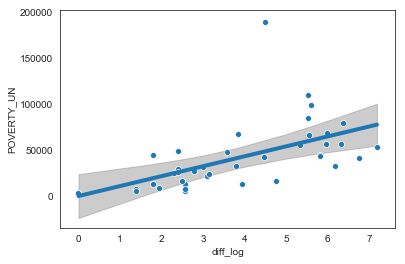

In [104]:
model = sm.OLS.from_formula("POVERTY_UN ~ diff_log", data=merged)
result = model.fit()
print(result.summary())

pr, cb, fv = predict_functional(result, "diff_log", ci_method="simultaneous")

ax = sns.lineplot(fv, pr, lw=4)
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("diff_log")
_ = ax.set_ylabel("POVERTY_UN")
sns.scatterplot(data=merged, 
                x=merged['diff_log'],
                y=merged['POVERTY_UN'], ax=ax)

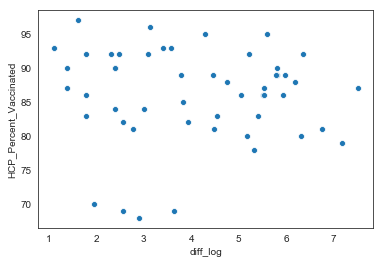

In [105]:
# https://data.ca.gov/dataset/health-care-personnel-influenza-vaccination
flu = pd.read_csv('./flu_vaccination.csv')
flu.rename(columns={"County": "county"}, inplace=True)

flu_per = flu[['county', 'HCP_Percent_Vaccinated']].groupby('county').mean().reset_index().copy()
merged_flu = pd.merge(left=covid_max, right=flu_per, left_on='county', right_on='county')

merged_flu['diff_log'] = np.log(merged_flu['newcountconfirmed'])
sns.scatterplot(data=merged_flu, 
                x=merged_flu['diff_log'],
                y=merged_flu['HCP_Percent_Vaccinated'])

In [106]:
model = sm.OLS.from_formula("HCP_Percent_Vaccinated ~ diff_log", data=merged_flu)
result = model.fit()
print(result.summary())

                              OLS Regression Results                              
Dep. Variable:     HCP_Percent_Vaccinated   R-squared:                       0.001
Model:                                OLS   Adj. R-squared:                 -0.019
Method:                     Least Squares   F-statistic:                   0.05761
Date:                    Tue, 07 Jul 2020   Prob (F-statistic):              0.811
Time:                            16:37:32   Log-Likelihood:                -170.03
No. Observations:                      51   AIC:                             344.1
Df Residuals:                          49   BIC:                             347.9
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

/Users/milad/anaconda/envs/mlbook/lib/python3.6/site-packages/statsmodels/sandbox/predict_functional.py:171: ValueWarning: 'newcountconfirmed', 'county' in data frame but not in summaries or values.
  ValueWarning)


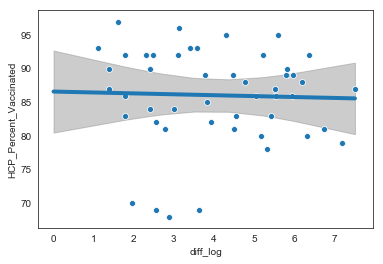

In [107]:
pr, cb, fv = predict_functional(result, "diff_log", ci_method="simultaneous")

ax = sns.lineplot(fv, pr, lw=4)
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("diff_log")
_ = ax.set_ylabel("HCP_Percent_Vaccinated")
sns.scatterplot(data=merged_flu, 
                x=merged_flu['diff_log'],
                y=merged_flu['HCP_Percent_Vaccinated'], ax=ax)

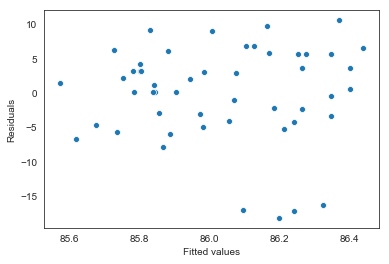

In [108]:
pp = sns.scatterplot(result.fittedvalues, result.resid)
pp.set_xlabel("Fitted values")
_ = pp.set_ylabel("Residuals")

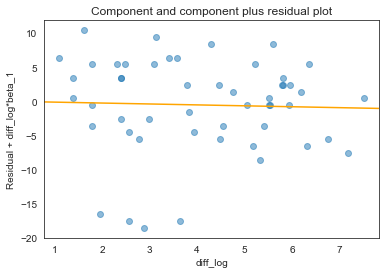

In [109]:
ax = plt.axes()
plot_ccpr(result, "diff_log", ax)
ax.lines[0].set_alpha(0.5)
_ = ax.lines[1].set_color('orange')

In [110]:
# https://data.ca.gov/dataset/city-expenditures-per-capita, https://data.ca.gov/dataset/county-expenditures-per-capita
#expenditure = pd.read_csv('./City_Expenditures_Per_Capita.csv')
#expenditure = expenditure[expenditure['Fiscal Year'] == 2016] # highest in the dataset

expenditure = pd.read_csv('./County_Expenditures_Per_Capita.csv')
expenditure = expenditure[expenditure['Fiscal Year'] == 2018] # highest in the dataset

expenditure.rename(columns={"Entity Name": "county", "Expenditures Per Capita": "EPC"}, inplace=True)

covid_max = data[['county','newcountconfirmed']].groupby(['county']).max().reset_index().copy()
expenditure_percapita = expenditure[['county', 'EPC']].groupby('county').mean().reset_index().copy()

merged_expenditure = pd.merge(left=covid_max, right=expenditure_percapita, left_on='county', right_on='county')
#merged_expenditure


                            OLS Regression Results                            
Dep. Variable:                    EPC   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     28.40
Date:                Tue, 07 Jul 2020   Prob (F-statistic):           2.06e-06
Time:                        16:37:37   Log-Likelihood:                -440.04
No. Observations:                  55   AIC:                             884.1
Df Residuals:                      53   BIC:                             888.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3472.1706    219.997     15.783      0.0

/Users/milad/anaconda/envs/mlbook/lib/python3.6/site-packages/statsmodels/sandbox/predict_functional.py:171: ValueWarning: 'newcountconfirmed', 'county' in data frame but not in summaries or values.
  ValueWarning)


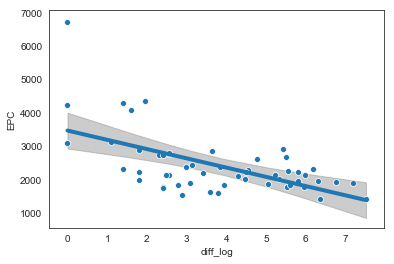

In [111]:
# outlier removal
z = np.abs(stats.zscore(merged_expenditure['EPC']))
outlier_idx = list(np.where(z > 3)[0])
merged_expenditure = merged_expenditure.drop(merged_expenditure.index[outlier_idx]).copy()

#sns.scatterplot(data=merged_expenditure, 
#                x=np.log(merged_expenditure['newcountconfirmed']),
#                y=merged_expenditure['EPC'])

merged_expenditure['diff_log'] = np.log(merged_expenditure['newcountconfirmed'])
model = sm.OLS.from_formula("EPC ~ diff_log", data=merged_expenditure)
result = model.fit()
print(result.summary())

pr, cb, fv = predict_functional(result, "diff_log", ci_method="simultaneous")

ax = sns.lineplot(fv, pr, lw=4)
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("diff_log")
_ = ax.set_ylabel("EPC")
sns.scatterplot(data=merged_expenditure, 
                x=merged_expenditure['diff_log'],
                y=merged_expenditure['EPC'], ax=ax)

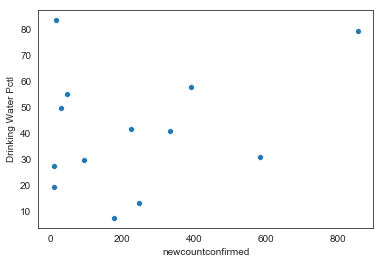

In [112]:
# https://data.ca.gov/dataset/calenviroscreen-2-0
water = pd.read_csv('./calenviroscreen-final-report.csv')
water.rename(columns={'California County': "county"}, inplace=True)
#print(water['county'].unique())

covid_max = data[['county','newcountconfirmed']].groupby(['county']).max().reset_index().copy()
water_per = water[['county', 'Drinking Water Pctl']].groupby('county').mean().reset_index().copy()
merged_water = pd.merge(left=covid_max, right=water_per, left_on='county', right_on='county')
merged_water
sns.scatterplot(data=merged_water, 
                x=merged_water['newcountconfirmed'],
                y=merged_water['Drinking Water Pctl'])